In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Twitter target Analysis with BERT and roBERTa transformers

In [2]:
!!pip install transformers -q

#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


<ipython-input-2-c84dd95314ac>:40: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

## Custom functions definition:

In [ ]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17)
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

# Loading the data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CS 522 Advanced Data Mining/CS 522 - Team 2/data/Twitter_data/Sampled_data/Training_sample')

In [ ]:
df.head()

,target,ids,date,flag,user,text
0,4,2054021495,Sat Jun 06 06:21:09 PDT 2009,NO_QUERY,tdes,Having fun with Photoshop. It's so amazing now...
1,0,2011558774,Tue Jun 02 19:12:30 PDT 2009,NO_QUERY,AshyJonas,"@AaL17 I'm at my course Haha, you do have fun..."
2,4,2184414822,Mon Jun 15 15:52:38 PDT 2009,NO_QUERY,itsyagirlbrit,@mikeyloops because its the best
3,0,1990222845,Mon Jun 01 04:15:15 PDT 2009,NO_QUERY,nhaszirah,"Ugh, I wanna get full marks for Equiz I DONT ..."
4,4,1553523792,Sat Apr 18 14:29:54 PDT 2009,NO_QUERY,JOLLY101,chattin wif my friend heidi


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  17000 non-null  int64 
 1   ids     17000 non-null  int64 
 2   date    17000 non-null  object
 3   flag    17000 non-null  object
 4   user    17000 non-null  object
 5   text    17000 non-null  object
dtypes: int64(2), object(4)
memory usage: 797.0+ KB


In [ ]:
## Duplicate tweets
df.drop_duplicates(subset='text',inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16986 entries, 0 to 16999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  16986 non-null  int64 
 1   ids     16986 non-null  int64 
 2   date    16986 non-null  object
 3   flag    16986 non-null  object
 4   user    16986 non-null  object
 5   text    16986 non-null  object
dtypes: int64(2), object(4)
memory usage: 928.9+ KB


In [ ]:
df = df[['text','target']]

In [ ]:
!!pip install demoji

import demoji

In [ ]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

def remove_emojis(text):
    return demoji.replace(text, '')

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [ ]:
texts_new = []
for t in df.text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(remove_emojis(t))))))

In [ ]:
df['text_clean'] = texts_new


In [ ]:
# df['text'] = df.text_clean

In [ ]:
df['text_clean'].head()

0    having fun with photoshop its so amazing now t...
1    im at my course haha you do have fun making pa...
2                                 because its the best
3     ugh i wanna get full marks for equiz i dont care
4                          chattin wif my friend heidi
Name: text_clean, dtype: object

In [ ]:
df['text_clean'][1:8].values

array(['im at my course haha you do have fun making paranoid maths tests very cool',
       'because its the best',
       'ugh i wanna get full marks for equiz i dont care',
       'chattin wif my friend heidi', 'cough cough cough no fun',
       'worth repeating',
       'lolyou know smosh those guys on youtube amp nooo poor leighton'],
      dtype=object)

In [ ]:
verify = df[df['text'].str.contains('Alphonse')]
# Apply the regular expression to the 'text' column of the DataFrame to count the number of alphabets
alphabet_counts = df['text'].str.contains('Alphonse')

# Print the resulting Series of alphabet counts
print(alphabet_counts.sum())

print(verify)

0
Empty DataFrame
Columns: [text, target, text_clean]
Index: []


In [ ]:
import re


verify = df[df['text'].str.contains('Amanda')]
# Apply the regular expression to the 'text' column of the DataFrame to count the number of alphabets
alphabet_counts = df['text'].str.contains('Amanda')

# Print the resulting Series of alphabet counts
print(alphabet_counts.sum())

print(verify)

8
                                                    text  target  \
708    @Amanda_Holden morning  when do u get bak from...       4   
6781   @grandsovereign nope to far away for me....tho...       4   
8098   had the most amazing time this weekend with Am...       4   
9782   @AmandaFClark the ties   http://twitpic.com/55ewu       4   
11273  @james__buckley i hope ouve got your suncream ...       0   
12845                           @TheRealAmandaa hello..        4   
13108               @LillianAmanda Have fun in Manning!        4   
15187        @Amanda_Holden  Good Luck for tonights BGT        4   

                                              text_clean  
708    morning when do u get bak from ny hope u have ...  
6781   nope to far away for metho im going to at4 in ...  
8098   had the most amazing time this weekend with am...  
9782                                            the ties  
11273  i hope ouve got your suncream on coz me and go...  
12845                          

In [ ]:
import re


verify = df[df['text'].str.contains('Frank')]
# Apply the regular expression to the 'text' column of the DataFrame to count the number of alphabets
alphabet_counts = df['text'].str.contains('Frank')

# Print the resulting Series of alphabet counts
print("Total: ",alphabet_counts.sum())
# print(verify.target)
print("Positives : ",len([x for x in verify.target if '4' in str(x)]))
print("Negatives : ",len([x for x in verify.target if '0' in str(x)]))
print(verify)


Total:  8
Positives :  3
Negatives :  5
                                                    text  target  \
377           i wish Frankie's weather report was wrong        0   
812    Kirk Franklin &amp; Family Korean Version:  2f...       4   
2071   @FrankieTheSats @unahealy are you performing t...       0   
7954   @FunTimeFrankieG THAT HAS GOT TO BE THE MOST D...       0   
8298   Watching OTH season 3 - Ellie just said 'I'm y...       4   
9634   ...and Sykes will lose a few gigs while gainin...       4   
11982  Home from Franklin street, I almost jumped ove...       0   
14699  @iamFrankBlack Who you telling? And I'm so afr...       0   

                                              text_clean  
377             i wish frankies weather report was wrong  
812    kirk franklin amp family korean version 2funny...  
2071   are you performing there today if yes i would ...  
7954   that has got to be the most disgusting spider ...  
8298   watching oth season 3 ellie just said im your

## Training

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 63


long tokenized sentences (with more than 80 tokens ):

In [ ]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

These sentences are not in english. They should be dropped.

In [ ]:
df['token_lens'] = token_lens

In [ ]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,text,target,text_clean,token_lens
15441,STUPid CRAZY FRUitY SwaaG.. lmao wtf.? oh well...,4,stupid crazy fruity swaag lmao wtf oh welll ay...,63
14060,I WANT MY FUKIN PHONE AGHHHHHHHHHHHHHHHHHHHHHH...,0,i want my fukin phone aghhhhhhhhhhhhhhhhhhhhhh...,53
11878,#seb-day #seb-day #seb-day #seb-day #seb-day #...,4,sebday sebday sebday sebday sebday sebday sebd...,47
16528,Google-maps link doesn't work in twitter I'm...,0,googlemaps link doesnt work in twitter im goin...,47
13795,Oimg ia m in the car waiting for them 2 drivre...,0,oimg ia m in the car waiting for them 2 drivre...,47
11105,hey my peeps wot u all up 2 ??? hav u watched...,4,hey my peeps wot u all up 2 hav u watched all ...,46
107,&amp; I Dont No How Im Going 2Survive When The...,0,amp i dont no how im going 2survive when they ...,45
9232,"@cuteungu bo, it's been ages x mrk pacaran. gw...",4,bo its been ages x mrk pacaran gw pikir lo bca...,45
5555,"..ngeliat km dan fb mu sekarang, bikin kesel m...",0,ngeliat km dan fb mu sekarang bikin kesel mulu...,44
9786,is done with this. i promise. no more. im thro...,4,is done with this i promise no more im through...,44


In [ ]:
df = df.iloc[12:]
df.head()

,text,target,text_clean,token_lens
4521,ugh! i go back 2 skool 2marow i totally shud ...,0,ugh i go back 2 skool 2marow i totally shud b ...,43
4040,goin w/ ofcm8s l8r 4 a mountain climbing/trek...,4,goin w ofcm8s l8r 4 a mountain climbingtrekkin...,43
11722,@lou7hood I so wish id gon2 croke no1 would go...,0,i so wish id gon2 croke no1 would go with me s...,42
14092,AAAAAAAAAAARGGGGGGGGH! this is annoying. i sti...,0,aaaaaaaaaaarggggggggh this is annoying i still...,42
2836,@bellamolina:Worse Day in 52Wks! Seriously! OO...,0,day in 52wks seriously ooohheemmmggeee novisit...,41


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

## Test data

In [ ]:
# token_lens_test = []
# df_test = df_test.dropna()

# for txt in df_test['text'].values:

#     tokens = tokenizer.encode(txt, max_length=512, truncation=True)
#     print(tokens)
#     token_lens_test.append(len(tokens))

# max_len=np.max(token_lens_test)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 63


# target column analysis

In [ ]:
df['target'].value_counts()

4    8487
0    8487
Name: target, dtype: int64

In [ ]:
# df['target'] = df['target'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [ ]:
# df_test['target'] = df_test['target'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [ ]:
df['target'].value_counts()

4    8487
0    8487
Name: target, dtype: int64

## Train - Validation - Test split

In [ ]:
X = df['text_clean'].values
y = df['target'].values
print(len(X))

16974


In [ ]:
# Split the data into train, validation and test subsets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=seed)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

X_test,X_train, y_test, y_train  = train_test_split(X, y, test_size=0.4108,  random_state=seed)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2829, random_state=seed)

print('Number of training samples:', len(X_train))
print('Number of validation samples:', len(X_valid))
print('Number of test samples:', len(X_test))

Number of training samples: 5000
Number of validation samples: 1973
Number of test samples: 10001


## One hot encoding

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print('Number of training samples:', len(X_train))
print('Number of validation samples:', len(X_valid))
print('Number of test samples:', len(X_test))

Number of training samples: 5000
Number of validation samples: 1973
Number of test samples: 10001


# BERT target Analysis

In [ ]:
MAX_LEN=128

In [ ]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

Then, we apply the tokenizer function to the train, validation and test sets.

In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

# BERT modeling

importing the BERT model from the pretrained library from Hugging face.

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
!!pip install tensorflow-addons

['Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/',
 'Collecting tensorflow-addons',
 '  Downloading tensorflow_addons-0.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (591 kB)',
 '\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/591.0 kB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b\x1b╸\x1b \x1b583.7/591.0 kB\x1b \x1b22.4 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b591.0/591.0 kB\x1b \x1b16.1 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25hRequirement already satisfied: packaging in /usr/local/lib/python3.10/dist-packages (from tensorflow-addons) (23.1)',
 'Collecting typeguard<3.0.0,>=2.7',
 '  Downloading typeguard-2.13.3-py3-none-any.whl (17 kB)',
 'Installing collected packages: typeguard, tensorflow-addons',
 'Successfully installed tensorflow-addons-0.20.0 typeguard-2.13.3']

In [ ]:
import tensorflow_addons as tfa

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from keras import optimizers
def create_model(bert_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = 'binary_crossentropy'
    metrics = ['acc',
                tfa.metrics.F1Score(num_classes=2,
                                                  average='macro',
                                                  threshold=0.5)]

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    embeddings = bert_model([input_ids,attention_masks])[1]

    output = tf.keras.layers.Dense(2, activation="sigmoid")(embeddings)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=metrics)


    return model

In [ ]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                           

In [ ]:
print(train_input_ids.dtype)
print(train_attention_masks.dtype)
print(y_train.dtype)


int64
int64
float64


In [ ]:
#Early stop setup
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_acc', patience=2, restore_best_weights=True)

history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid),callbacks=early_stop,epochs=8, batch_size=30)

Epoch 1/8
167/167 [==============================] - 215s 844ms/step - loss: 0.5932 - acc: 0.6976 - f1_score: 0.6639 - val_loss: 0.4446 - val_acc: 0.7998 - val_f1_score: 0.7994
Epoch 2/8
167/167 [==============================] - 140s 840ms/step - loss: 0.4005 - acc: 0.8258 - f1_score: 0.8232 - val_loss: 0.4077 - val_acc: 0.8206 - val_f1_score: 0.8183
Epoch 3/8
167/167 [==============================] - 142s 849ms/step - loss: 0.2898 - acc: 0.8934 - f1_score: 0.8932 - val_loss: 0.4625 - val_acc: 0.8165 - val_f1_score: 0.8147
Epoch 4/8
167/167 [==============================] - 142s 850ms/step - loss: 0.1822 - acc: 0.9348 - f1_score: 0.9356 - val_loss: 0.5322 - val_acc: 0.8094 - val_f1_score: 0.8082


# BERT results

In [ ]:
result_bert = model.predict([test_input_ids,test_attention_masks])

313/313 [==============================] - 92s 285ms/step


In [ ]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

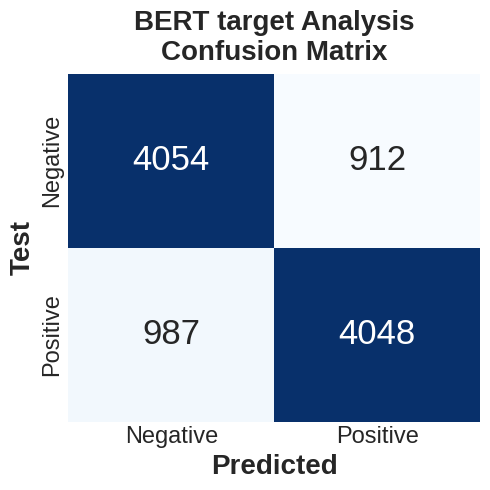

In [ ]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT target Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for BERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Positive']))

	Classification Report for BERT:

               precision    recall  f1-score   support

    Negative       0.80      0.82      0.81      4966
    Positive       0.82      0.80      0.81      5035

   micro avg       0.81      0.81      0.81     10001
   macro avg       0.81      0.81      0.81     10001
weighted avg       0.81      0.81      0.81     10001
 samples avg       0.81      0.81      0.81     10001



In [ ]:
model.save('/content/drive/MyDrive/CS 522 Advanced Data Mining/CS 522 - Team 2/models and bias probabilities/cleaned_data_bert_1e-5_bert-bs_30_epoch-8.h5')

# RoBERTa target Analysis

import the tokenizer used to train the original roberta transformer by Facebook.

In [ ]:
tokenizer_roberta = RobertaTokenizerFast.from_pretrained("roberta-base")

to check the length of the longest tokenized sentence by roberta tokenizer:

In [ ]:
token_lens = []
for txt in X_train:
    tokens = tokenizer_roberta.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
max_length=np.max(token_lens)
max_length

44

In [ ]:
MAX_LEN=128

the tokenization function

In [ ]:
def tokenize_roberta(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer_roberta.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
train_input_ids, train_attention_masks = tokenize_roberta(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize_roberta(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize_roberta(X_test, MAX_LEN)

# RoBERTa modeling

In [ ]:
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [ ]:
def create_model(roberta_model, max_len=MAX_LEN):

    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = 'binary_crossentropy'
    metrics = ['acc',
                tfa.metrics.F1Score(num_classes=2,
                                                  average='macro',
                                                  threshold=0.5)]

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    output = roberta_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(2, activation="sigmoid")(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(opt, loss=loss, metrics=metrics)
    return model

In [ ]:
model = create_model(roberta_model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_3[0][0]',                
 el)                            thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [ ]:
print(train_input_ids.dtype)
print(train_attention_masks.dtype)
print(y_train.dtype)

history_2 = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_valid),  callbacks=early_stop,epochs=8, batch_size=30)

int64
int64
float64
Epoch 1/8
167/167 [==============================] - 200s 908ms/step - loss: 0.5288 - acc: 0.7370 - f1_score: 0.7313 - val_loss: 0.4217 - val_acc: 0.8079 - val_f1_score: 0.8086
Epoch 2/8
167/167 [==============================] - 139s 835ms/step - loss: 0.3846 - acc: 0.8354 - f1_score: 0.8357 - val_loss: 0.3988 - val_acc: 0.8196 - val_f1_score: 0.8190
Epoch 3/8
167/167 [==============================] - 142s 854ms/step - loss: 0.3094 - acc: 0.8734 - f1_score: 0.8727 - val_loss: 0.4149 - val_acc: 0.8251 - val_f1_score: 0.8240
Epoch 4/8
167/167 [==============================] - 143s 857ms/step - loss: 0.2415 - acc: 0.9042 - f1_score: 0.9057 - val_loss: 0.4840 - val_acc: 0.8322 - val_f1_score: 0.8304
Epoch 5/8
167/167 [==============================] - 142s 852ms/step - loss: 0.1745 - acc: 0.9352 - f1_score: 0.9344 - val_loss: 0.5749 - val_acc: 0.8140 - val_f1_score: 0.8129
Epoch 6/8
167/167 [==============================] - 142s 853ms/step - loss: 0.1271 - acc: 0.95

# RoBERTa results

In [ ]:
result_roberta = model.predict([test_input_ids,test_attention_masks])

313/313 [==============================] - 87s 264ms/step


In [ ]:
y_pred_roberta =  np.zeros_like(result_roberta)
y_pred_roberta[np.arange(len(y_pred_roberta)), result_roberta.argmax(1)] = 1

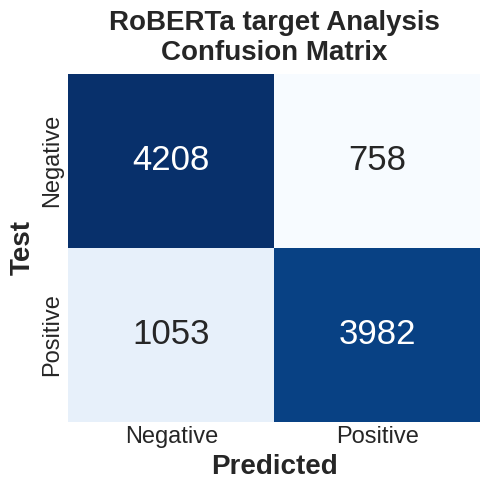

In [ ]:
conf_matrix(y_test.argmax(1),y_pred_roberta.argmax(1),'RoBERTa target Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for RoBERTa:\n\n',classification_report(y_test,y_pred_roberta, target_names=['Negative', 'Positive']))

	Classification Report for RoBERTa:

               precision    recall  f1-score   support

    Negative       0.80      0.85      0.82      4966
    Positive       0.84      0.79      0.81      5035

   micro avg       0.82      0.82      0.82     10001
   macro avg       0.82      0.82      0.82     10001
weighted avg       0.82      0.82      0.82     10001
 samples avg       0.82      0.82      0.82     10001



# Results Summary

## BERT Classification Report

In [ ]:
print('Classification Report for BERT:\n',classification_report(y_test,y_pred_bert, target_names=['Negative', 'Positive']))

Classification Report for BERT:
               precision    recall  f1-score   support

    Negative       0.80      0.82      0.81      4966
    Positive       0.82      0.80      0.81      5035

   micro avg       0.81      0.81      0.81     10001
   macro avg       0.81      0.81      0.81     10001
weighted avg       0.81      0.81      0.81     10001
 samples avg       0.81      0.81      0.81     10001



## RoBERTa Classification Report

In [ ]:
print('Classification Report for RoBERTa:\n',classification_report(y_test,y_pred_roberta, target_names=['Negative',  'Positive']))

Classification Report for RoBERTa:
               precision    recall  f1-score   support

    Negative       0.80      0.85      0.82      4966
    Positive       0.84      0.79      0.81      5035

   micro avg       0.82      0.82      0.82     10001
   macro avg       0.82      0.82      0.82     10001
weighted avg       0.82      0.82      0.82     10001
 samples avg       0.82      0.82      0.82     10001



## Classification Matrix Comparison

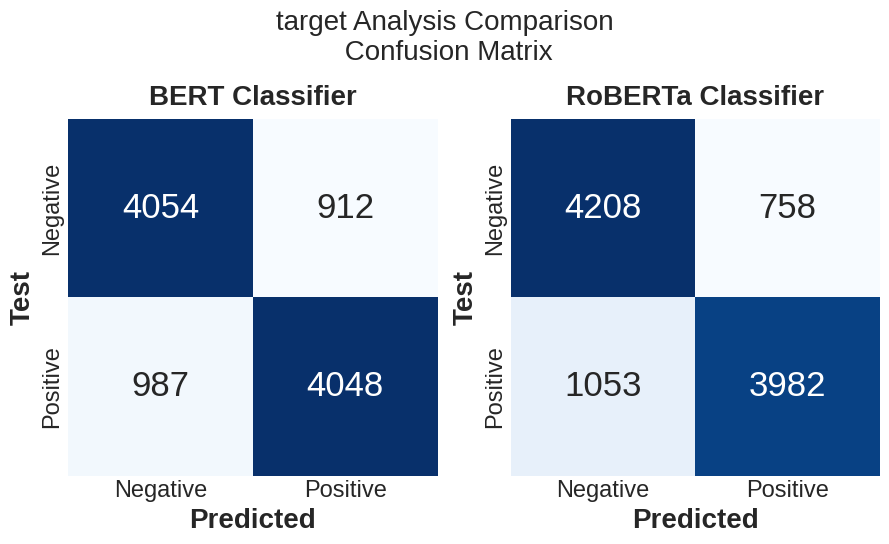

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(9,5.5))

labels = ['Negative', 'Positive']
plt.suptitle('target Analysis Comparison\n Confusion Matrix', fontsize=20)


sns.heatmap(confusion_matrix(y_test.argmax(1),result_bert.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[0], annot_kws={"size":25})

ax[0].set_title('BERT Classifier', fontsize=20)
ax[0].set_yticklabels(labels, fontsize=17);
ax[0].set_xticklabels(labels, fontsize=17);
ax[0].set_ylabel('Test', fontsize=20)
ax[0].set_xlabel('Predicted', fontsize=20)

sns.heatmap(confusion_matrix(y_test.argmax(1),result_roberta.argmax(1)), annot=True, cmap="Blues", fmt='g', cbar=False, ax=ax[1], annot_kws={"size":25})
ax[1].set_title('RoBERTa Classifier', fontsize=20)
ax[1].set_yticklabels(labels, fontsize=17);
ax[1].set_xticklabels(labels, fontsize=17);
ax[1].set_ylabel('Test', fontsize=20)
ax[1].set_xlabel('Predicted', fontsize=20)


plt.show()

In [ ]:

model.save('/content/drive/MyDrive/CS 522 Advanced Data Mining/CS 522 - Team 2/models and bias probabilities/cleaned_data_roberta_1e-5_roberta-bs-30_epoch-8.h5')